In [21]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor as DecisionTree
import numpy as np
import math
import matplotlib.pyplot as plt

from scipy.interpolate import UnivariateSpline as spline

In [3]:
#Creating X, Y and adding random noise to relationship

X = np.linspace(.1,12,500)
Y = np.sin(X)/X + np.random.normal(0,.2,len(X)) 


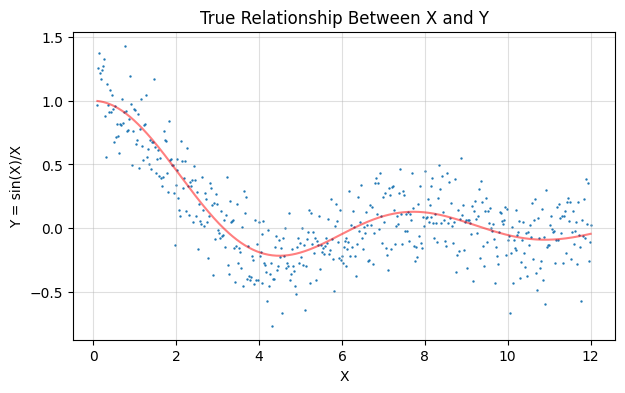

In [42]:
#plotting data and underlying relationship

plt.figure(figsize = (7,4))

plt.scatter(X, Y, s = .5)
plt.plot(X, np.sin(X)/X, color = "red", alpha = .5)

plt.title("True Relationship Between X and Y")
plt.ylabel("Y = sin(X)/X")
plt.xlabel("X")
plt.grid(alpha = .4)
plt.show()

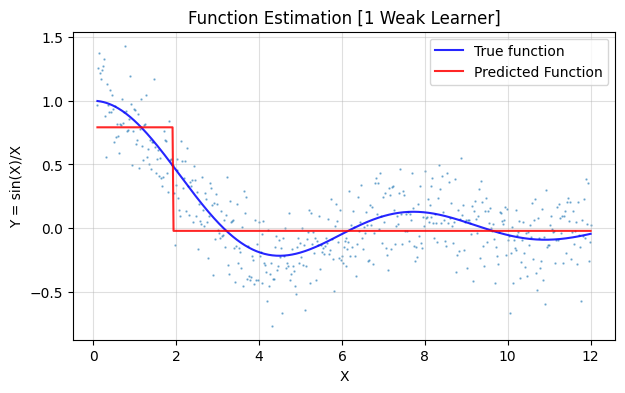

In [43]:
#comparing data and true realtionship to estimate after 1 iteration

temp = DecisionTree(max_depth = 1)
temp.fit(X.reshape(len(X),1), Y)
plt.figure(figsize = (7,4))

plt.scatter(X, Y, s = .5, alpha = .5)
plt.plot(X, np.sin(X)/X, color = "blue", alpha = .85, label = "True function")

predictions = temp.predict(X.reshape(len(X),1))
plt.plot(X,predictions,color = "red", alpha = .85, label = "Predicted Function")

plt.title("Function Estimation [1 Weak Learner]")
plt.ylabel("Y = sin(X)/X")
plt.xlabel("X")
plt.legend()
plt.grid(alpha = .4)

plt.show()

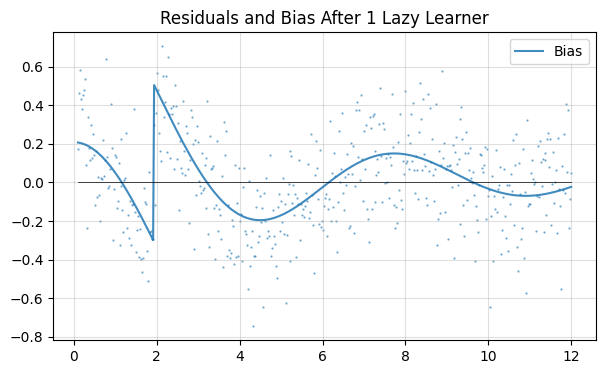

In [44]:
#plotting residuals and bias of model after 1 iteration

plt.figure(figsize = (7,4))
residuals = Y - predictions

plt.scatter(X,residuals, alpha = .5, s = .5)
plt.plot(X,np.sin(X)/X - predictions, alpha = .85, label = "Bias")

plt.title("Residuals and Bias After 1 Lazy Learner")
plt.plot(X,[0]*len(X),color = "black", lw = .5)
plt.legend()
plt.grid(alpha = .4)

plt.show()

In [7]:
class GradientBoostedTreeRegressor:
    
    #stepDepth: depth of tree created at each iteration
    #iterations: how many trees of depth stpDepth to be created
    def __init__(self, stepDepth = 1, iterations = 20):
        self.stepDepth = stepDepth
        self.iterations = iterations
    
    def fit(self, x, y):
        #storing fitting data to GBTR object
        self.x = x
        self.y = y
        
        #converting x into a column vector
        x = x.reshape(len(x),1)
        
        #initialing error to be Y and making it a column vector
        #starting model is f(x) = 0
        residualError = y.reshape(len(y),1)
        trees = []
        
        #note: while loop used to later implement stopping at overfit threshold
        step = 1
        while(step <= self.iterations):
            #setting response of interest to be most recent model's residuals
            newData = residualError[:,-1]
            tempTree = DecisionTree(max_depth = 1)
            tempTree.fit(x.reshape(len(x),1), newData)
            predictions = tempTree.predict(x.reshape(len(x),1))
            tempResids = newData - predictions
            
            #adding new residuals and tree to np array/list
            residualError = np.append(residualError, tempResids.reshape(len(tempResids),1), 1)
            trees.append(tempTree)
    
            step += 1
        self.trees = trees
            
    def predict(self,newX):
        length = len(newX)
        temp_predictions = np.zeros(length).reshape(length,1)
        
        #adding predictions into
        for t in self.trees:
            temp_predictions += t.predict(newX).reshape(length,1)
        return temp_predictions
    
    def plot(self, show = True, size = 1):
        plt.figure(figsize = (10*(size**.5),6*(size**.5)))
        
        plt.scatter(self.x, self.y, s = .5, alpha = .5, label = "True Value")
        
        fittedValueDomain = np.linspace(min(self.x), max(self.x), len(self.x)*3)
        plt.plot(fittedValueDomain, self.predict(fittedValueDomain.reshape(len(fittedValueDomain),1)), 
                 color = "red", lw = 1, label = "Fitted Value")
        
        plt.title("Gradient Boosted Tree Regresssor Function Estimate [" + str(self.iterations) + " Iterations]")
        plt.grid(alpha = .3)
        plt.legend()
        if(show):
            plt.show()

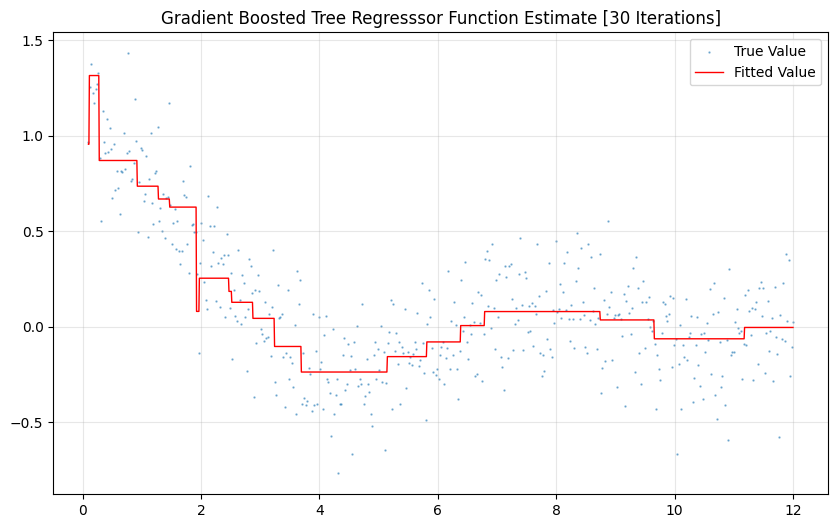

In [8]:
NewGBTree = GradientBoostedTreeRegressor(iterations = 30)
NewGBTree.fit(X,Y)
NewGBTree.plot()

In [9]:
start = 2
end = 8

predictionMat = np.zeros((len(X),end-start))

for i in np.arange(start,end):
    NewGBTree = GradientBoostedTreeRegressor(iterations = i**2)
    NewGBTree.fit(X,Y)
    predictionMat[:,i-start] = NewGBTree.predict(X.reshape(len(X),1)).T[0]

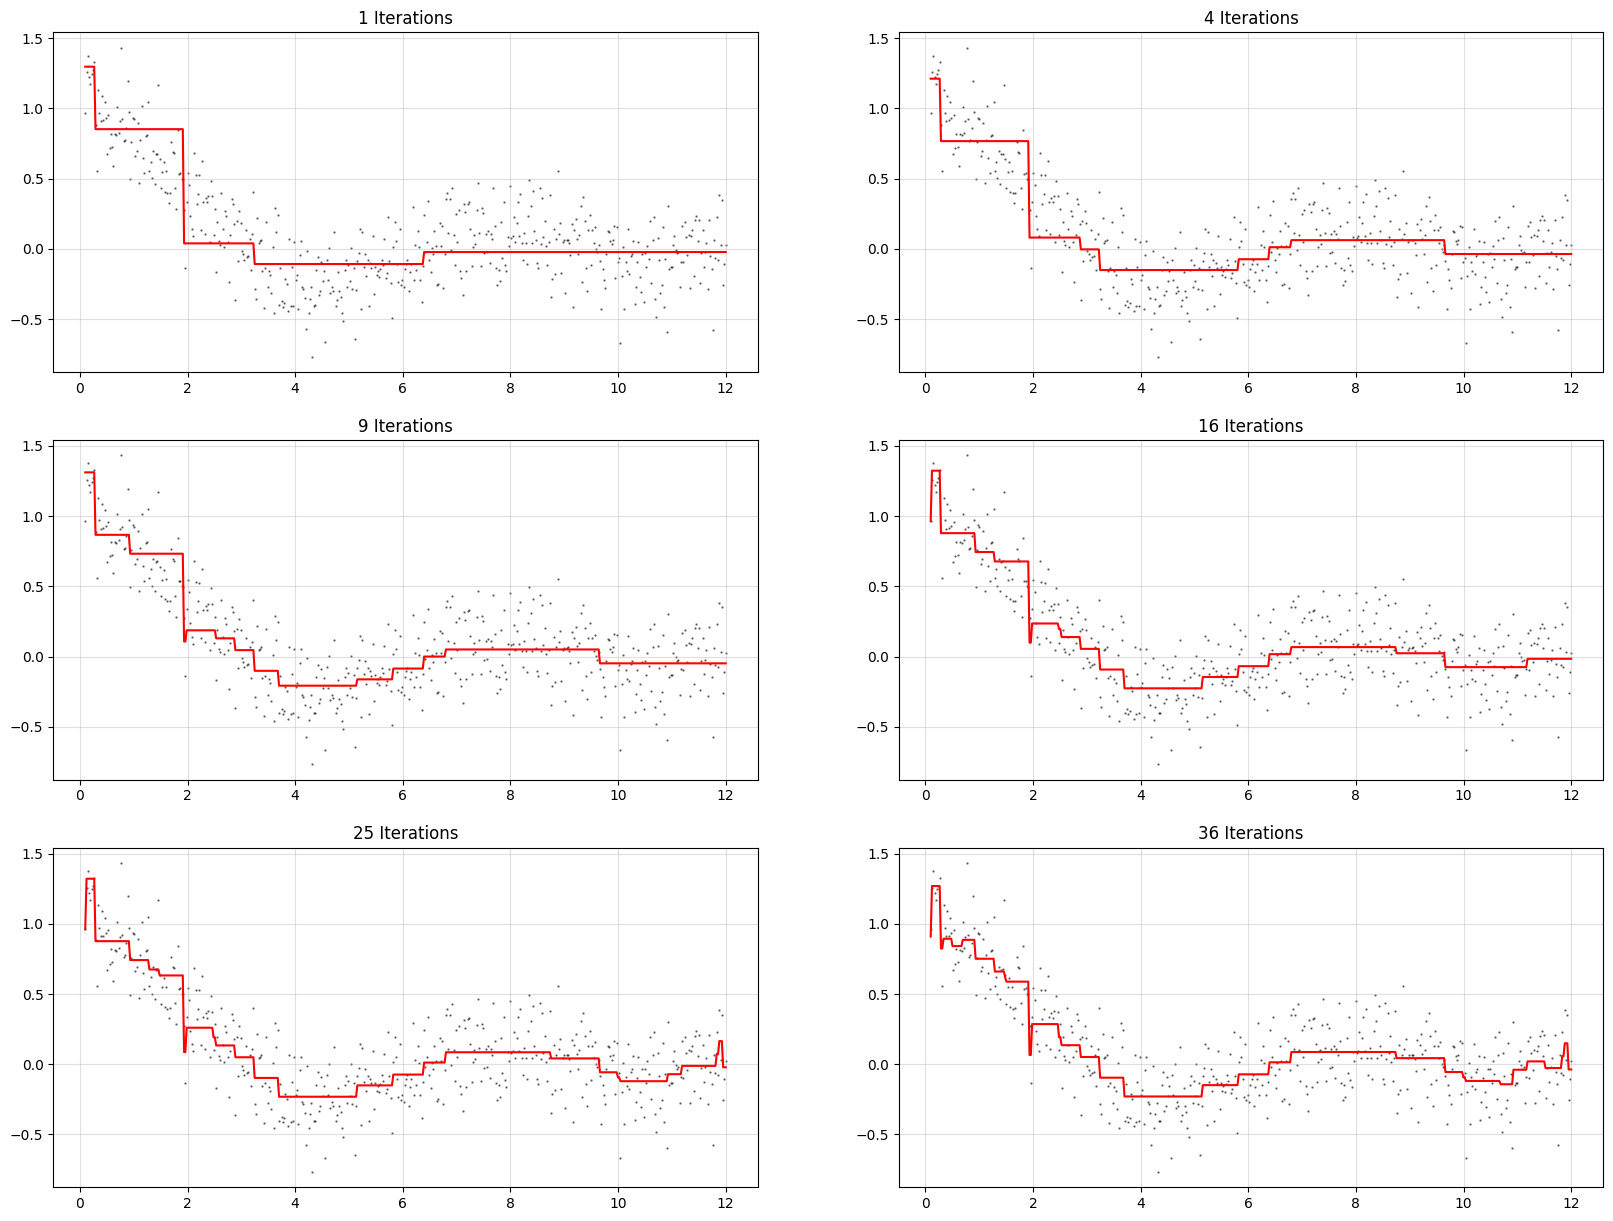

In [45]:
numPlotRows = int(np.ceil(len(predictionMat.T)/2))
plt.figure(figsize = (20,5*numPlotRows))
plotsize = numPlotRows * 100

for i in range(len(predictionMat.T)):
    #placing plot into subplot
    #subplot 321 is the 1st plot in a 3x2 grid of plots
    
    plt.subplot(plotsize + 21 + i)

    plt.scatter(X, Y, s = .5, alpha = .5, label = "True Value", color = 'black')
    plt.plot(X, predictionMat.T[i], lw = 1.5, color = "red")

    plt.grid(alpha = .4)
    plt.title(str((start + i)**2) + " Iterations")


## Prediction Error vs. Iterations

In [ ]:
#range of iterations to perform CV on
start = 1
end = 50

folds = 100
errs = []

for i in range(start,end):
    #vecor of prediction error for each fold
    errorVec = np.zeros(folds)
    
    for f in range(folds):
        xTrain, xTest, yTrain, yTest = train_test_split(X,Y, test_size = 1/folds)
        NewGBTree.iterations = i
        NewGBTree.fit(xTrain,yTrain)
        predictions = NewGBTree.predict(xTest.reshape(len(xTest),1)).T[0]
        errorVec[f] = np.mean((predictions - yTest)**2)
        
        #NewGBTree.plot()
    if(i%3 == 0):
        print(i,"done")
        
    
    errs.append(np.mean(errorVec))






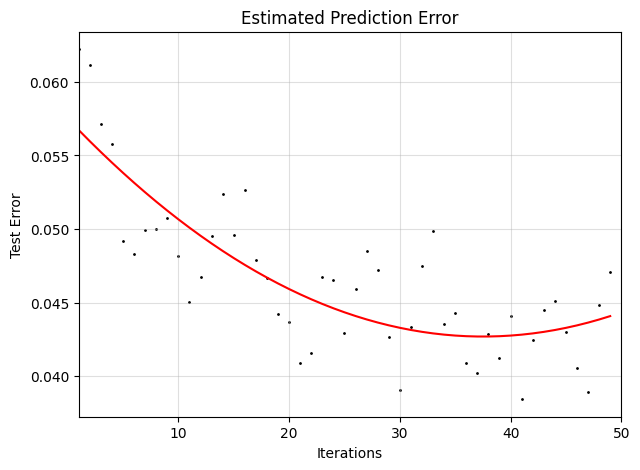

In [41]:
iter_vec = np.linspace(start, end - 1, end - 1)
pred_error_spline = spline(iter_vec, errs, k = 2)

plt.figure(figsize = (7,5))

plt.scatter(iter_vec, errs, 
            color = "black", label = "prediction error", s = 1)
plt.plot(iter_vec, pred_error_spline(iter_vec), 
         color = "red")


plt.xlabel("Iterations")
plt.ylabel("Test Error")
plt.title("Estimated Prediction Error")
plt.grid(alpha = .4)
plt.axis([start,end,None,None])

plt.show()
